## Open notebook in:
| Colab                                 |  Gradient                                                                                                                                         |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH03/ch03_text_summarization.ipynb)                                              | [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH03/ch03_text_summarization.ipynb)|             

# Download repo

In [1]:
# Clone repo, if it's not already cloned, to be sure all runs on smoothly
# on Colab, Kaggle or Paperspace
import os

if not os.path.isdir('Transformers-in-Action'):
    !git clone https://github.com/Nicolepcx/Transformers-in-Action.git
else:
    print('Repository already exists. Skipping clone.')


current_path = %pwd
if '/Transformers-in-Action' in current_path:
    new_path = current_path + '/utils'
else:
    new_path = current_path + '/Transformers-in-Action/utils'
%cd $new_path

Repository already exists. Skipping clone.
/content/Transformers-in-Action/utils


# About this notebook

Welcome to this exciting notebook, where we dive into the world of text summarization using a variety of cutting-edge models and techniques. In this notebook, we will put several state-of-the-art Transformer-based models, including BART, T5, ProphetNet and Pegasus to the test. As a baseline, we will also explore a TextRank-based model to compare their performance. Our objective is to analyze the efficacy and suitability of these models in generating summaries for different types of datasets, such as [CNN daily](https://huggingface.co/datasets/cnn_dailymail) news articles and [arXiv scientific papers](https://huggingface.co/datasets/scientific_papers).
To further challenge these models, we will utilize the BigBird and Longformer architectures, which are specifically designed to handle longer input sequences. This will enable us to examine the models' performance on the CNN daily and arXiv datasets, which consist of diverse content and varying text lengths.
In this notebook, you can expect to:
1. Gain an introduction to the various text summarization models, including their key features and limitations.
2. Learn how to implement and utilize these models to generate summaries for different types of text.
3. Assess the models' performance on multiple samples from the CNN daily and arXiv datasets using both ROUGE and BLEU metrics for an in-depth comparison.
4. Understand the significance of evaluating models on a diverse set of samples to achieve a more dependable and generalizable performance evaluation.
5. Discover the challenges associated with assessing models on complex and domain-specific datasets, and how the BigBird and Longformer architectures can help address these issues.

By the end of this notebook, you will have a comprehensive understanding of various text summarization models, their performance on different datasets, and the intricacies involved in evaluating models on complex, domain-specific data. Let's embark on this fascinating journey and unlock the potential of these powerful text summarization models!

# Install requirements

In [2]:
!pip install -U tensorflow==2.12.0 -q
!pip install -U keras==2.12.0 -q
!pip install -U tensorflow-gcs-config==2.12.0 -q
!pip install -U tensorflow-probability==0.20.1 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 26.7 MB/s eta 0:00:00


In [3]:
from requirements import *

In [4]:
install_base_packages()
install_required_packages_ch03()

Installing base requirements...

✅ transformers==4.26.1 installation completed successfully!

✅ datasets==2.10.1 installation completed successfully!

Installing chapter 3 requirements...

✅ summa==1.2.0 installation completed successfully!

✅ evaluate==0.4.0 installation completed successfully!

✅ rouge_score==0.1.2 installation completed successfully!

✅ pyarrow==9.0.0 installation completed successfully!

✅ sentencepiece installation completed successfully!



# Imports

In [5]:
from setup import *
from utils import *
from textrank import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
useGPU()

Have fun with this chapter!🥳


In [7]:
import pandas as pd
import numpy as np
from functools import partial

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import networkx as nx

from summa import summarizer
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, set_seed
from transformers import LEDForConditionalGeneration, LEDTokenizer
from transformers import BartConfig, BartForConditionalGeneration
from transformers import LEDConfig, LEDForConditionalGeneration
from transformers import BigBirdPegasusForConditionalGeneration, AutoTokenizer
import torch
from datasets import load_dataset

from multiprocessing import Pool
import evaluate
from tqdm import tqdm

import matplotlib.pyplot as plt

from textwrap import TextWrapper

set_seed(42)

In [8]:
%%capture
!pip install watermark

In [9]:
%load_ext watermark
%watermark -a "Nicole Koenigstein" -gu "Nicolepcx" -u -d -v -m

Author: Nicole Koenigstein

Github username: Nicolepcx

Last updated: 2024-01-17

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.58+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



# Allocate enough RAM

Let us try to get a __GPU__ with at least __15GB RAM__ for our notebook.

In [10]:
# crash colab to get more RAM -> uncomment to use
# !kill -9 -1

We can execute the following command `!free -h`  to see if we have enough RAM and `!nvidia-smi` to get more info about our GPU type we got assigned.
If the allocated GPU is too small, the above cell can be used to run the command to crash the notebook hoping to get a better GPU after the crash, since the GPU is randomly allocated.


In [11]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            50Gi       1.3Gi        12Gi       4.0Mi        37Gi        49Gi
Swap:             0B          0B          0B


In [12]:
!nvidia-smi

Wed Jan 17 14:00:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# TextRank Algorithmus

The custom `TextRank` class is designed to create a graph-based representation of a given text, where each node in the graph corresponds to a sentence, and the edges between nodes represent the similarity between sentences. This graph-based representation provides an intuitive way to visualize and understand the relationships among sentences in the text.

Using a graph to represent text is particularly useful for tasks like text summarization, where identifying the most important and representative sentences is crucial. By representing the text as a graph, the TextRank algorithm can leverage the graph structure to rank sentences based on their importance in the overall text.

TextRank is an unsupervised graph-based ranking algorithm inspired by Google's PageRank algorithm. It was first introduced in the paper ["TextRank: Bringing Order into Texts"](https://aclanthology.org/W04-3252/) by Mihalcea and Tarau (2004). The TextRank class in the code below constructs a graph by calculating the cosine similarity between sentences using the Bag of Words (BoW) and TF-IDF representation of the sentences. The higher the similarity, the stronger the connection between the sentences in the graph. By plotting this graph, we can visually explore the relationships among sentences and better understand the structure and organization of the text.

In [13]:
# We use the first paragraph for the original Transformer paper
# "Attention Is All You Need"
text = "Recurrent neural networks, long short-term memory [13] and gated recurrent [7] \
neural networks in particular, have been firmly established as state of the art approaches \
in sequence modeling and transduction problems such as language modeling and machine translation [35, 2, 5]. Numerous \
efforts have since continued to push the boundaries of recurrent language models and encoder-decoder architectures [38, 24, 15]. \
Recurrent models typically factor computation along the symbol positions of the input and output \
sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden \
states ht, as a function of the previous hidden state ht−1 and the input for position t. This inherently \
sequential nature precludes parallelization within training examples, which becomes critical at longer \
sequence lengths, as memory constraints limit batching across examples. Recent work has achieved \
significant improvements in computational efficiency through factorization tricks [21] and conditional \
computation [32], while also improving model performance in case of the latter. The fundamental \
constraint of sequential computation, however, remains. \
Attention mechanisms have become an integral part of compelling sequence modeling and transduction models \
in various tasks, allowing modeling of dependencies without regard to their distance in \
the input or output sequences [2, 19]. In all but a few cases [27], however, such attention mechanisms \
are used in conjunction with a recurrent network. \
In this work we propose the Transformer, a model architecture eschewing recurrence and instead \
relying entirely on an attention mechanism to draw global dependencies between input and output. \
The Transformer allows for significantly more parallelization and can reach a new state of the art in \
translation quality after being trained for as little as twelve hours on eight P100 GPUs."

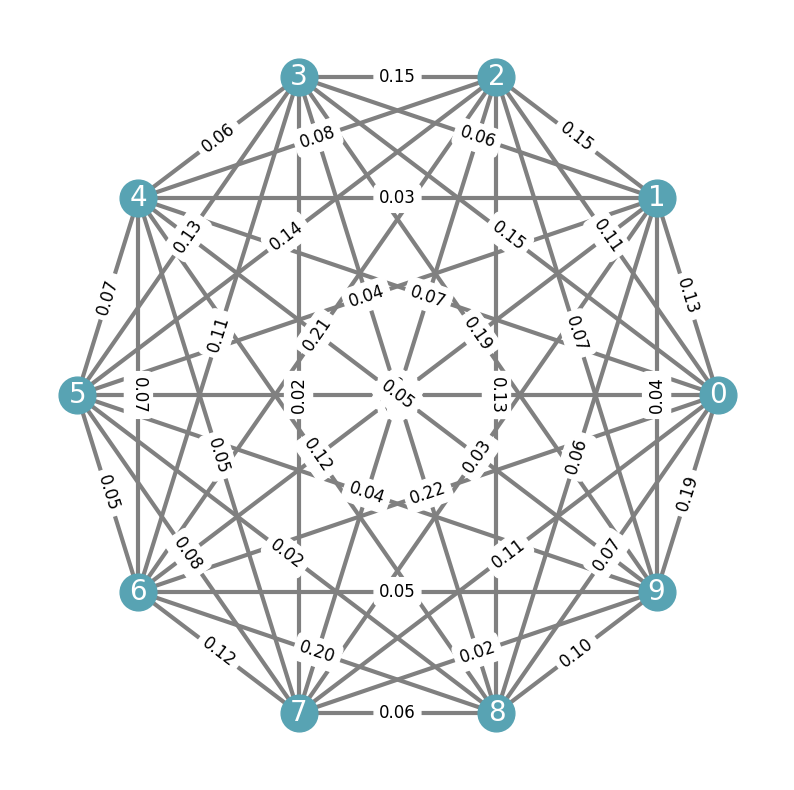

In [14]:
tr = TextRank()
sentences = tr.split_sentences(text)
G = tr.create_graph(sentences)
tr.plot_graph(G)

This plot shows a circular graph where each node represents a sentence from the input text. The edges connecting the nodes represent the similarity between the sentences, which is calculated using cosine similarity based on the TF-IDF representation of the sentences.

The numbers displayed on the edges are the weights of the edges, representing the cosine similarity scores between the connected sentences. These scores range from 0 to 1, where 0 indicates no similarity and 1 indicates a perfect match (identical sentences). A higher number implies a stronger connection between the two sentences, meaning they share more words or terms in common.

This graphical representation of the text allows us to visually analyze the relationships between the sentences in the input text. Which can help identify clusters of similar sentences or detect isolated sentences that might be less related to the main topics discussed in the text.

## TextRank Example from Book

 Text is represented as a graph, with nodes representing textual units (sentences or words) and edges representing the relationships between them.
The scores for each node are calculated on the basis of the scores of its neighbors and the weights of the edges that connect them. First, the algorithm applies the PageRank equation as an iteration:

\begin{equation}
p_i^{(k+1)}=\frac{1-\delta}{N}+\delta \cdot \sum_{\text {edges }_{j i}} \frac{p_j^{(k)}}{c_j}
\end{equation}

Then, as a second step, the PageRank is replaced by the rank $r$ of the vertices $V_{i}$, which can stand for words, phrases or complete sentences.

\begin{equation}
r\left(V_i^{(k+1)}\right)=\frac{1-\delta}{N}+\delta \cdot \sum_{\text {edges }_{j i}} \frac{\omega_{j i} \cdot r\left(V_j^{(k)}\right)}{\sum_{\text {edges }_{ji}} \omega_{j i}}
\end{equation}

Additionally, to each edge a weight $w_{ji}$ is attached in order to have more flexibility to characterize the \emph{strength} of the connection between two vertices $V_j$ and $V_i$. Depending on the use case, these edges can represent different types of connection, lexical relations, or contextual relations.

The pagerank function `def pagerank()` from the class `class TextRank` reflects the second equation, where $\omega_{j i}$ is the weight of the connection between vertices $V_j$ and $V_i$ (i.e., adjacency\_matrix[j, i]). The function calculates the rank $r(V_i^{(k+1)})$ for each vertex $V_i$ in the graph, considering the edge weights and the out-degree of each node.

Sentence Weights:
Sentence 0: Machine learning is a subfield of artificial intelligence.
Sentence 3: Unsupervised learning is another machine learning technique.
Weight: 0.2469

Sentence 0: Machine learning is a subfield of artificial intelligence.
Sentence 2: Supervised learning is a popular machine learning technique.
Weight: 0.2469

Sentence 0: Machine learning is a subfield of artificial intelligence.
Sentence 1: Deep learning is a technique used in machine learning.
Weight: 0.2210

Sentence 0: Machine learning is a subfield of artificial intelligence.
Sentence 0: Machine learning is a subfield of artificial intelligence.
Weight: 1.0000

Sentence 1: Deep learning is a technique used in machine learning.
Sentence 3: Unsupervised learning is another machine learning technique.
Weight: 0.4522

Sentence 1: Deep learning is a technique used in machine learning.
Sentence 2: Supervised learning is a popular machine learning technique.
Weight: 0.4522

Sentence 1: Deep learning is a techniq

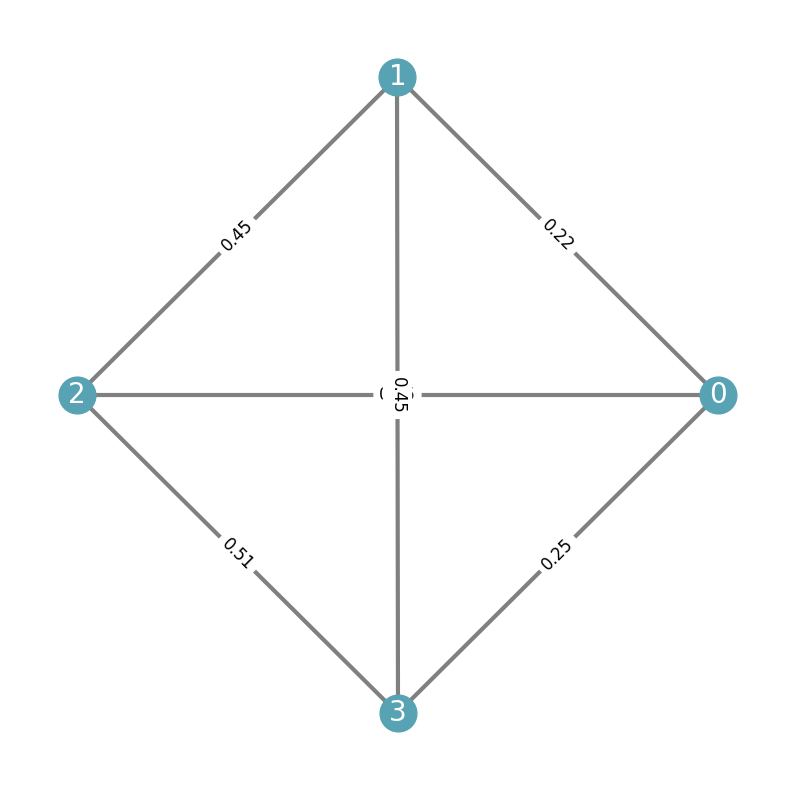

In [15]:
text = """
    Machine learning is a subfield of artificial intelligence.
    Deep learning is a technique used in machine learning.
    Supervised learning is a popular machine learning technique.
    Unsupervised learning is another machine learning technique.
    """

tr = TextRank()
sentences = tr.split_sentences(text)
G = tr.create_graph(sentences)
tr.print_sentence_weights(G, sentences)
tr.plot_graph(G)

# Use case CNN/Daily mail dataset

The [CNN/Daily Mail dataset](https://huggingface.co/datasets/cnn_dailymail) is a popular choice for evaluating text summarization models in the NLP community. This dataset consists of news articles from CNN and Daily Mail websites, along with their human-generated summaries, also known as "highlights" or "story points." It provides a large and diverse set of real-world articles and their corresponding summaries, making it an excellent benchmark for testing the performance of various summarization models.

The dataset is interesting as an example use case for several reasons:

1. Real-world data: The articles and summaries are sourced from actual news websites, which makes the dataset representative of the kind of content users might encounter and want to summarize in real-life scenarios.

2. Diversity: The dataset covers a wide range of topics, such as politics, sports, entertainment, and technology. This diversity helps evaluate how well a summarization model can generalize across different domains and subject matters.

3. Abstractive summarization: The human-generated highlights often involve rephrasing and paraphrasing of the original content, which requires a deeper understanding of the text. This makes the dataset suitable for testing the capabilities of abstractive summarization models, which aim to generate summaries that capture the main points of the input text while using new, concise, and coherent sentences.

4. Large-scale: With over 300,000 articles and summaries, the CNN/Daily Mail dataset is large enough to train and evaluate deep learning models, such as Transformer-based models, which often require substantial amounts of data to achieve high performance.

By using the CNN/Daily Mail dataset as an example use case, we can evaluate various Transformer-based summarization models on a challenging, diverse, and real-world dataset, which will give us valuable insights into their performance and potential applications.

## Load the CNN/Daily mail dataset

In [16]:
# Load the CNN/Daily mail dataset
dataset = load_dataset('cnn_dailymail', version='3.0.0')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
dataset_train = load_dataset('cnn_dailymail', version='3.0.0', split='train')
dataset_train.set_format(type='pandas', columns=['article', 'highlights'])

In [18]:
# Convert to pandas DataFrame
df = dataset_train.to_pandas()

## Excerpt of article and ground truth of summary




In [19]:
# Access first row using iloc
sample = df.iloc[0]

excerpt = 1000

print(f"\033[1mExcerpt of {excerpt} characters, total length of article: \
{len(sample['article'])}:\033[0m\n")

print(sample["article"][:excerpt])
print(f"\033[1m\n\nSummary (length: {len(sample['highlights'])}):\033[0m\n")
print(sample["highlights"])


Excerpt of 1000 characters, total length of article: 2527:

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains
access to a reported £20 million ($41.1 million) fortune as he turns
18 on Monday, but he insists the money won't cast a spell on him.
Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the
Phoenix" To the disappointment of gossip columnists around the world,
the young actor says he has no plans to fritter his cash away on fast
cars, drink and celebrity parties. "I don't plan to be one of those
people who, as soon as they turn 18, suddenly buy themselves a massive
sports car collection or something similar," he told an Australian
interviewer earlier this month. "I don't think I'll be particularly
extravagant. "The things I like buying are things that cost about 10
pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to
gamble in a casino, buy a drink in a pub or see the horror film
"Hostel: Part II," currently six places below his

In [20]:
articles_np= np.array(dataset_train['article'])
articles_np.shape

(287113,)

In [21]:
articles_np_1 = articles_np[:1]
articles_np_1.shape

(1,)

In [22]:
articles_np_1

array(['LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. De

## Establishing a baseline:
### Applying TextRank algorithm to CNN/Daily mail dataset


TextRank is a good choice as a baseline algorithm for text summarization because it is unsupervised, easy to implement, and computationally efficient. It provides a simple yet effective way to extract key phrases and rank sentences based on their importance within the text. Compared to other baseline choices, such as lead-3 (selecting the first three sentences) or simple frequency-based methods, TextRank offers a more sophisticated approach by capturing the relationships between sentences and their relevance to the overall text, giving a better starting point for comparison with advanced methods like Transformer-based models.

This code snippet is used to generate summaries for a collection of texts (in this case, news article) using the TextRank algorithm. The TextRank summarization is implemented with the summa library, which is available on [PyPI](https://pypi.org/project/summa/). The implementation is based on the paper Mihalcea, R., Tarau, P.: [“TextRank: Bringing order into texts”](https://aclanthology.org/W04-3252/)

A `summarize_text` function is defined, which takes in two arguments - text and words. text is the input text to be summarized, and words is an optional parameter to specify the target number of words in the generated summary (default is 250 words). The `summarizer.summarize()` function from the summa library is used to generate the summary.

The code then employs the multiprocessing Pool class to parallelize the summarization process. This speeds up the computation by taking advantage of multiple CPU cores available on the system. The `Pool()` context manager creates a pool of worker processes, and the `pool.map()` function is used to apply the `summarize_text` function to each element of the `articles_np_1` array (which contains the input articles).

The `pool.map()` function distributes the articles across the available worker processes, and each process applies the summarize_text function independently. Once all the summaries are generated, they are collected and stored in the `summarized_articles` list. This parallelization can significantly improve the performance of the TextRank summarization, especially when working with large datasets.


In [23]:
# Define the function to summarize the text
def summarize_text(text, words=80):
    summary = summarizer.summarize(text, words=words)
    return summary

# Parallelize the TextRank summarization
with Pool() as pool:
    summarized_articles = pool.map(summarize_text, articles_np_1)


### Get summarized article

In [24]:
summarized_articles

['LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him.\nDaniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties.']

In [25]:
references = np.array(dataset_train['highlights'])

In [26]:
references_np = np.array(references)
references_np[:1]

array(["Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have been held in trust fund ."],
      dtype=object)

In [27]:
reference = references[0]

In [28]:
print(summarized_articles[0])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains
access to a reported £20 million ($41.1 million) fortune as he turns
18 on Monday, but he insists the money won't cast a spell on him.
Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the
Phoenix" To the disappointment of gossip columnists around the world,
the young actor says he has no plans to fritter his cash away on fast
cars, drink and celebrity parties.


In [29]:
summaries = {}
summaries['TextRank (Baseline)'] = summarized_articles

In [30]:
print(summaries['TextRank (Baseline)'][0])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains
access to a reported £20 million ($41.1 million) fortune as he turns
18 on Monday, but he insists the money won't cast a spell on him.
Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the
Phoenix" To the disappointment of gossip columnists around the world,
the young actor says he has no plans to fritter his cash away on fast
cars, drink and celebrity parties.


# Appyling Transformers to the CNN/Daily mail dataset

In this section, we define a function `generate_summary` that takes a `model_name` and a `sample_text` as input and generates a summary of the input text using the specified model. We support multiple summarization models such as:
- BART [Modelcard](https://huggingface.co/facebook/bart-large-cnn), [Paper](https://arxiv.org/abs/1910.13461)
- T5 [Modelcard](https://huggingface.co/sysresearch101/t5-large-finetuned-xsum-cnn), [Paper](https://arxiv.org/abs/1910.10683)
- ProphetNet [Modelcard](), [Paper](https://arxiv.org/abs/2001.04063)
- Pegasus [Modelcard](https://huggingface.co/google/pegasus-cnn_dailymail), [Paper](https://arxiv.org/abs/1912.08777)
- GPT-2 [Modelcard](https://huggingface.co/gpt2-xl), [Paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

The function sets up the tokenizer and model based on the given model_name and uses the Hugging Face's pipeline to perform the summarization.

For the CNN/Daily Mail dataset use case, we aim to evaluate different transformer models to understand their performance in summarizing news articles. The dataset contains long news articles with associated human-generated summaries, making it a great resource for benchmarking and comparing various summarization models.

By using multiple models for summarization, we can gain insights into the strengths and weaknesses of each approach, and understand how they perform in a real-world scenario. This helps us to identify the most suitable model for our specific use case, considering factors such as quality, speed, and resource requirements.

The choice of using the Hugging Face's pipeline function allows for a streamlined and easy-to-use interface for handling pre-processing, model inference, and post-processing steps. This simplifies the code and makes it more maintainable and user-friendly, especially for those who may not have extensive experience with transformers or NLP.

In [31]:
set_seed(42)

def generate_summary(model_name, sample_text):
    """
    Generate a summary of the input text using a specified model.

    Args:
        model_name (str): The name of the model to use for summarization. Supported values are "BART", "T5",
            "ProphetNet", "Pegasus", and "GPT-2".
        sample_text (str): The input text to summarize.

    Returns:
        str: The summary generated by the specified model.

    Raises:
        ValueError: If the specified model is not supported.

    Notes:
        - If `model_name` is "Pegasus", the `google/pegasus-cnn_dailymail` model will be used for summarization.
          This model doesn't require a tokenizer or a maximum length.
        - If `model_name` is "GPT-2", the `gpt2-xl` model will be used for text generation. The summary will be
          generated by extracting the first paragraph from the generated text that follows the "TL;DR:" token.

    Example:
        >>> generate_summary("BART", "This is an example text to summarize using BART.")
        'BART is used to summarize the input text.'
    """

    # Set up tokenizer and model
    model_dict = {
        "BART": "facebook/bart-large-cnn",
        "T5": "sysresearch101/t5-large-finetuned-xsum-cnn",
        "ProphetNet": "microsoft/prophetnet-large-uncased-cnndm"
    }

    if model_name == "Pegasus":
        # Generate summary using the specified model
        summarization_pipeline = pipeline("summarization", model="google/pegasus-cnn_dailymail")
        summarization_output = summarization_pipeline(sample_text)
        summary = summarization_output[0]["summary_text"].replace(" .<n>", ".\n")
    elif model_name in model_dict.keys():
        tokenizer = AutoTokenizer.from_pretrained(model_dict[model_name])
        model = AutoModelForSeq2SeqLM.from_pretrained(model_dict[model_name])
        summarization_pipeline = pipeline("summarization", tokenizer=tokenizer, model=model)
        # Generate summary using the specified model
        summarization_output = summarization_pipeline(sample_text, max_length=100)
        summary = summarization_output[0]["summary_text"]
    elif model_name == "GPT-2":
        text_generation_pipeline = pipeline("text-generation", model="gpt2-xl")
        # Generate summary using the specified model
        gpt2_query = sample_text + "\nTL;DR:\n"
        pipe_out = text_generation_pipeline(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
        summary = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))
    else:
        raise ValueError(f"Model {model_name} is not supported.")

    return summary


## Generate summary from  <font color='red'>"Pegasus"</font> model

In [32]:
sample_text = sample[0]
summaries["Pegasus"] = generate_summary("Pegasus", sample_text)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

## Generate summary from  <font color='red'>"BART"</font> model

In [33]:
summaries["BART"] = generate_summary("BART", sample_text)
summaries["BART"]

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['model.shared.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


"Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund. Details of how he'll mark his landmark birthday are under wraps."

## Generate summary from  <font color='red'>"T5"</font> model

In [34]:
summaries["T5"] = generate_summary("T5", sample_text)
summaries["T5"]

Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


'Harry Potter star Daniel Radcliffe says he has no plans to fritter away his fortune as he turns 18 . "I don\'t think I\'ll be particularly extravagant," he says.'

## Generate summary from  <font color='red'>"ProphetNet"</font> model

In [35]:
summaries["ProphetNet"] = generate_summary("ProphetNet", sample_text)

## Evaluate all models incl. baseline on CNN/Daily mail dataset

### Evaluating Summarization Models using ROUGE and BLEU Metrics

In this section, we demonstrate how to evaluate the summarization models using both the ROUGE and BLEU metrics. We use the Hugging Face's implementation of these metrics.

ROUGE, or Recall-Oriented Understudy for Gisting Evaluation, is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing. The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation. Note that ROUGE is case insensitive, meaning that upper case letters are treated the same way as lower case letters.
[Link](https://huggingface.co/spaces/evaluate-metric/rouge)

BLEU, or Bilingual Evaluation Understudy, is an evaluation metric used primarily for machine translation. It measures the similarity between a candidate translation and a set of reference translations, considering both the n-gram precision and a brevity penalty factor.
[Link](https://huggingface.co/spaces/evaluate-metric/google_bleu)

[Info about Huggingface evaluate](https://huggingface.co/docs/evaluate/v0.4.0/en/package_reference/loading_methods#evaluate.load)
<br> <br>

__Note:__ It can be beneficial to use both ROUGE and BLEU metrics for evaluation, as they focus on different aspects of the generated summaries. ROUGE is recall-oriented and mainly focuses on the coverage of important content, while BLEU is precision-oriented and evaluates the fluency and correctness of the generated text.

It is important to have an understanding of what constitutes a "good" score when evaluating summarization models. Here are some guidelines for interpreting the ROUGE and BLEU scores:

__ROUGE Scores__

ROUGE scores usually range from 0 to 1, with 1 being a perfect match between the generated summary and the reference summary. In practice, scores closer to 1 are rare, especially for abstractive summarization tasks.

For a simple baseline model like TextRank or LSA, a "good" ROUGE score can be around 0.3 to 0.4. For more advanced Transformer-based models like BART, T5, or Pegasus, a "good" ROUGE score can range from 0.4 to 0.6, depending on the task and dataset. State-of-the-art models can achieve even higher scores, but it's important to keep in mind that ROUGE scores are just one aspect of evaluating the quality of generated summaries.

There exist different variants of ROUGE, which consider different aspects of the summaries, such as n-grams and the longest common subsequence.


__BLEU Scores__

BLEU scores also range from 0 to 1, with 1 indicating a perfect match between the generated text and the reference text. However, BLEU scores tend to be lower compared to ROUGE scores, as they are more sensitive to the differences in word order and phrasing.

For a simple baseline model, a "good" BLEU score could be around 0.1 to 0.2. For Transformer-based models, a "good" BLEU score might range from 0.2 to 0.4, again depending on the task and dataset. State-of-the-art models can achieve higher scores, but just like with ROUGE, it's essential to consider other factors when evaluating the quality of generated summaries.

Keep in mind that these are rough guidelines, and the definition of a "good" score can vary depending on the specific domain, dataset, and evaluation criteria. It is always a good idea to compare your model's scores with scores from existing state-of-the-art models on the same dataset to get a better understanding of its performance.


__Defining the SummarizationMetrics Class__

The SummarizationMetrics class is defined with methods for computing the ROUGE and BLEU metrics, as well as a method to compute both metrics together:

`class SummarizationMetrics:
    ...
`

This class is located in the `utils.py` file, feel free to look it up to get a better understanding how the mectrics are computed.

__Computing Metrics__

To compute the metrics, we first instantiate the SummarizationMetrics class:
`evaluator = SummarizationMetrics()
`

Then, we call the compute_sum_metric method on the evaluator object, passing the generated summaries and the reference summary:
`metrics_df = evaluator.compute_sum_metric(summaries, reference)
`

The compute_sum_metric method computes both the ROUGE and BLEU metrics by calling the `compute_rouge_metrics` and `compute_google_bleu_metrics` methods, respectively. The resulting metrics are combined into a single DataFrame and returned.

__Viewing the Metrics__

We can display the resulting metrics DataFrame to see the evaluation scores for each model:
`metrics_df
`

This DataFrame shows the ROUGE and BLEU scores for each summarization model, allowing for an easy comparison of their performance.


__Note:__ It's crucial to understand that evaluating a summarization model based on just one text example from a testing dataset is not enough to determine its overall performance. The reason behind this is that the complexity of the text samples can vary significantly within a dataset. Some text samples might be easier for a model to summarize, while others could be more challenging, containing complex sentence structures, domain-specific jargon, or long and convoluted narratives.

To get a more comprehensive sense of a model's performance, it is essential to evaluate it on a larger number of samples from the testing dataset. By doing so, we can ensure that we're assessing the model's ability to handle a diverse set of inputs, including those that differ in complexity, topic, and structure. This approach provides a more reliable and generalizable evaluation of the model's performance, helping us to better understand its strengths and weaknesses.

In the next section of this notebook, we will expand our evaluation to include multiple text samples from the testing dataset. This will give us a better understanding of how well the model performs across a variety of inputs and allow us to make more informed decisions about its applicability to real-world use cases.

In [36]:
evaluator = SummarizationMetrics()

metrics_df = evaluator.compute_sum_metric(summaries, reference)

metrics_df


100%|██████████| 5/5 [00:00<00:00, 199.38it/s]


,rouge1,rouge2,rougeL,rougeLsum,google_bleu
TextRank (Baseline),0.436975,0.324786,0.386555,0.436975,0.196133
Pegasus,0.800000,0.692308,0.800000,0.800000,0.656627
BART,0.613636,0.372093,0.545455,0.568182,0.315534
T5,0.550725,0.417910,0.376812,0.521739,0.341772
ProphetNet,0.446602,0.257426,0.407767,0.407767,0.105590


## Compare all model summaries incl. baseline on CNN/Daily mail dataset

In [37]:
print_summaries(summaries, reference)

Ground truth
Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18
Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in
trust fund .


TextRank (Baseline)
['LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe
gains access to a reported £20 million ($41.1 million) fortune as he
turns 18 on Monday, but he insists the money won\'t cast a spell on
him.\nDaniel Radcliffe as Harry Potter in "Harry Potter and the Order
of the Phoenix" To the disappointment of gossip columnists around the
world, the young actor says he has no plans to fritter his cash away
on fast cars, drink and celebrity parties.']

--------------------------------------------------------------------

Pegasus
Harry Potter star Daniel Radcliffe gains access to a reported £20
million fortune.
Young actor says he has no plans to fritter his cash away.
Radcliffe's earnings from the first five Potter films have been held


# Use case arxiv: scientic paper summarization

In [38]:
# Load the dataset
test_dataset = load_dataset("scientific_papers", "arxiv", split="test")
test_dataset.set_format(type='pandas', columns=['article', 'abstract'])


In [39]:
# Convert to pandas DataFrame
df = test_dataset.to_pandas()

In [40]:
sample = df.iloc[0]

In [41]:
excerpt = 1500

print(f"\033[1mExcerpt of {excerpt} characters, total length of article: \
{len(sample['article'])}:\033[0m\n")

print(sample["article"][:excerpt])
print(f"\033[1m\n\nSummary (length: {len(sample['abstract'])}):\033[0m\n")
print(sample["abstract"])


Excerpt of 1500 characters, total length of article: 32828:

for about 20 years the problem of properties of short - term changes
of solar activity has been considered extensively .
many investigators studied the short - term periodicities of the
various indices of solar activity .
several periodicities were detected , but the periodicities about 155
days and from the interval of @xmath3 $ ] days ( @xmath4 $ ] years )
are mentioned most often .
first of them was discovered by @xcite in the occurence rate of gamma
- ray flares detected by the gamma - ray spectrometer aboard the _
solar maximum mission ( smm ) .
this periodicity was confirmed for other solar flares data and for the
same time period @xcite .
it was also found in proton flares during solar cycles 19 and 20
@xcite , but it was not found in the solar flares data during solar
cycles 22 @xcite .
_    several autors confirmed above results for the daily sunspot area
data . @xcite studied the sunspot data from 18741984 .
she fou

In [42]:
# Convert the pandas series to a numpy array
papers_np = test_dataset["article"].to_numpy()

papers_np.shape

(6440,)

In [43]:
papers_np_1 = papers_np[:1]
papers_np_1.shape

(1,)

In [44]:
# Define a new function with the `words` argument fixed to 120
summarize_text_120 = partial(summarize_text, words=120)

# Parallelize the TextRank summarization
with Pool() as pool:
    summarized_articles = pool.map(summarize_text_120, papers_np_1)

In [45]:
references_arxiv = test_dataset["abstract"][:1].tolist()

In [46]:
references_arxiv = np.array(test_dataset["abstract"])

In [47]:
references_arxiv_np = np.array(references_arxiv)
print(references_arxiv_np[:1])

[' the short - term periodicities of the daily sunspot area
fluctuations from august 1923 to october 1933 are discussed . for
these data \n the correlative analysis indicates negative correlation
for the periodicity of about @xmath0 days , but the power spectrum
analysis indicates a statistically significant peak in this time
interval . \n a new method of the diagnosis of an echo - effect in
spectrum is proposed and it is stated that the 155-day periodicity is
a harmonic of the periodicities from the interval of @xmath1 $ ] days
.    the autocorrelation functions for the daily sunspot area
fluctuations and for the fluctuations of the one rotation time
interval in the northern hemisphere , separately for the whole solar
cycle 16 and for the maximum activity period of this cycle do not show
differences , especially in the interval of @xmath2 $ ] days . \n it
proves against the thesis of the existence of strong positive
fluctuations of the about @xmath0-day interval in the maximum activit

In [48]:
reference = references_arxiv[0]

In [49]:
print(reference)

 the short - term periodicities of the daily sunspot area fluctuations
from august 1923 to october 1933 are discussed . for these data
 the correlative analysis indicates negative correlation for the
periodicity of about @xmath0 days , but the power spectrum analysis
indicates a statistically significant peak in this time interval .
 a new method of the diagnosis of an echo - effect in spectrum is
proposed and it is stated that the 155-day periodicity is a harmonic
of the periodicities from the interval of @xmath1 $ ] days .    the
autocorrelation functions for the daily sunspot area fluctuations and
for the fluctuations of the one rotation time interval in the northern
hemisphere , separately for the whole solar cycle 16 and for the
maximum activity period of this cycle do not show differences ,
especially in the interval of @xmath2 $ ] days .
 it proves against the thesis of the existence of strong positive
fluctuations of the about @xmath0-day interval in the maximum activity
period

In [50]:
print(summarized_articles[0])

the autocorrelation function of the time series @xmath90 ( the lower
curve in figure [ f3 ] ) has only one statistically significant peak
for @xmath98 months ( 480 days ) and negative values for @xmath99 $ ]
months ( [ 90 , 390 ] days ) .
two effects cause the existence of the peak of the periodogram of the
time series of sunspot area fluctuations at about @xmath0 days : the
first is caused by the 27-day periodicity , which probably creates the
162-day periodicity ( it is a subharmonic frequency of the 27-day
periodicity ) and the second is caused by statistically significant
positive values of the autocorrelation function from the intervals of
@xmath165 $ ] and @xmath166 $ ] days .


In [51]:
sample_text = sample[0]

In [52]:
summaries_arxiv = {}
summaries_arxiv['TextRank (Baseline)'] = summarized_articles

## Generate summary from  <font color='red'>"BigBirdPegasus"</font> model

BigBird, is a sparse-attention based transformer which extends Transformer based models, such as BERT to much longer sequences. Moreover, BigBird comes along with a theoretical understanding of the capabilities of a complete transformer that the sparse model can handle. BigBird was introduced in this [paper](https://arxiv.org/abs/2007.14062).
<br><br>

__Model description__

BigBird relies on block sparse attention instead of normal attention (i.e. BERT's attention) and can handle sequences up to a length of 4096 at a much lower compute cost compared to BERT. It has achieved SOTA on various tasks involving very long sequences such as long documents summarization, question-answering with long contexts.

The models checkpoint is obtained after fine-tuning BigBirdPegasusForConditionalGeneration for summarization on arxiv dataset from scientific papers.

In [53]:
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-arxiv")

# by default encoder-attention is `block_sparse` with num_random_blocks=3, block_size=64
model = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv")

# decoder attention type can't be changed & will be "original_full"
# you can change `attention_type` (encoder only) to full attention like this:
model = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv", attention_type="original_full")

# you can change `block_size` & `num_random_blocks` like this:
model = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv", block_size=16, num_random_blocks=2)

text = sample_text
inputs = tokenizer.encode_plus(text, return_tensors='pt',max_length=4096, truncation=True)
prediction = model.generate(**inputs)
prediction = tokenizer.batch_decode(prediction)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 256 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [54]:
summaries_arxiv['bigbird-pegasus'] = prediction

In [55]:
summaries_arxiv['bigbird-pegasus'] = summaries_arxiv['bigbird-pegasus'][0]
summaries_arxiv['bigbird-pegasus']

'<s> a method of analysis of the short - term changes of solar activity based on the analysis of the periodograms is developed.<n> the method is based on the analysis of the periodograms of the power spectrum of the change of solar activity.<n> the periodograms of the power spectrum of the change of solar activity are obtained by using the autocorrelation function of the change of solar activity.<n> the periodograms of the power spectrum of the change of solar activity are obtained by using the blackman - tukey power spectrum method.<n> the blackman - tukey method is used for the analysis of the periodograms of the power spectrum of the change of solar activity.<n> the periodograms of the power spectrum of the change of solar activity are obtained by using the kolmogorov - smirnov power spectrum method.<n> the kolmogorov - smirnov power spectrum method is used for the analysis of the periodograms of the power spectrum of the change of solar activity.<n> the kolmogorov - smirnov power s

## Generate summary from  <font color='red'>"Longformer"</font> model

First, it's important to note that the scores, such as ROUGE, for shorter text are generally higher than for longer text. This is because shorter text is easier to summarize accurately, and the metrics can capture the essence of the original text more effectively. In the case of the Longformer, its strong performance on longer text sequences is particularly noteworthy, as it demonstrates the model's ability to handle more complex summarization tasks effectively. This further emphasizes the strength of the Longformer and its potential for various text summarization applications.

Comparing the Longformer with other models on longer text, such as the arXiv dataset, can provide valuable insights into their performance. The arXiv dataset consists of scientific articles, which tend to be long and complex, making it an ideal benchmark for text summarization models.

For example, BART has achieved good results on the arXiv dataset. However, due to its limitations in handling longer text sequences, it may not be as effective as the Longformer. T5 has also demonstrated competitive performance on longer text summarization tasks, but it may still fall short when compared to the Longformer's capabilities.

Models like PEGASUS and BigBird, which have been designed with summarization-specific pre-training objectives, have shown promise on long text summarization tasks as well. However, as mentioned earlier, the Longformer outperforms these models despite not having a summarization-specific pre-training objective.

In summary, while other models have demonstrated varying levels of success on longer text summarization tasks such as the arXiv dataset, the Longformer stands out due to its ability to handle longer text sequences effectively and achieve high scores on various metrics, such as ROUGE.

The [official paper](https://arxiv.org/pdf/2004.05150.pdf) reports a new state-of-the-art __ROUGE-2 score of 19.62__ on the whole test dataset (WikiLingua dataset) which aligns very well with our observation here. LED significantly outperforms [PEGASUS](https://huggingface.co/transformers/model_doc/pegasus.html) and also slightly outperforms [BigBird](https://arxiv.org/abs/2007.14062) despite *PEGASUS* and
*BigBird* making use of a "summarization-specific" pre-training objective.

As a comparison, BART achieved a __ROUGE-2 score of 17.50__ on the arXiv dataset. It's important to note that these scores are for the standard BART model, which has limitations in handling longer text sequences.

In [56]:
LONG_ARTICLE = sample_text
LONG_ARTICLE

'for about 20 years the problem of properties of short - term changes of solar activity has been considered extensively .\nmany investigators studied the short - term periodicities of the various indices of solar activity .\nseveral periodicities were detected , but the periodicities about 155 days and from the interval of @xmath3 $ ] days ( @xmath4 $ ] years ) are mentioned most often .\nfirst of them was discovered by @xcite in the occurence rate of gamma - ray flares detected by the gamma - ray spectrometer aboard the _ solar maximum mission ( smm ) .\nthis periodicity was confirmed for other solar flares data and for the same time period @xcite .\nit was also found in proton flares during solar cycles 19 and 20 @xcite , but it was not found in the solar flares data during solar cycles 22 @xcite .\n_    several autors confirmed above results for the daily sunspot area data . @xcite studied the sunspot data from 18741984 .\nshe found the 155-day periodicity in data records from 31 ye

In [57]:
sample_text

'for about 20 years the problem of properties of short - term changes of solar activity has been considered extensively .\nmany investigators studied the short - term periodicities of the various indices of solar activity .\nseveral periodicities were detected , but the periodicities about 155 days and from the interval of @xmath3 $ ] days ( @xmath4 $ ] years ) are mentioned most often .\nfirst of them was discovered by @xcite in the occurence rate of gamma - ray flares detected by the gamma - ray spectrometer aboard the _ solar maximum mission ( smm ) .\nthis periodicity was confirmed for other solar flares data and for the same time period @xcite .\nit was also found in proton flares during solar cycles 19 and 20 @xcite , but it was not found in the solar flares data during solar cycles 22 @xcite .\n_    several autors confirmed above results for the daily sunspot area data . @xcite studied the sunspot data from 18741984 .\nshe found the 155-day periodicity in data records from 31 ye

In [58]:

tokenizer = LEDTokenizer.from_pretrained("allenai/led-large-16384-arxiv")

input_ids = tokenizer(LONG_ARTICLE, padding="max_length", max_length=16384, return_tensors="pt", truncation=True).input_ids.to("cuda")
global_attention_mask = torch.zeros_like(input_ids)
# Put global attention on <s> token
global_attention_mask[:, 0] = 1

model = LEDForConditionalGeneration.from_pretrained("allenai/led-large-16384-arxiv", return_dict_in_generate=True).to("cuda")

sequences = model.generate(input_ids, global_attention_mask=global_attention_mask, max_length=512, num_beams=4).sequences

summary = tokenizer.batch_decode(sequences, skip_special_tokens=True)

In [59]:
summaries_arxiv['Longformer'] = summary

In [60]:
summaries_arxiv['Longformer'] = summaries_arxiv['Longformer'][0]
summaries_arxiv['Longformer']

' a new method of the detection of statistically significant peaks of the periodograms is presented. \n two effects cause the existence of the peak of the periodogram of the time series of sunspot area fluctuations at about @xmath0 days : the first is caused by the 27-day periodicity, which probably creates the 162-day periodicity ( it is a subharmonic frequency of the 27-day periodicity ) and the second is caused by statistically significant positive values of the autocorrelation function from the intervals of @xmath1 $ ] and @xmath2 $ ] days. \n the existence of the periodicity of about @xmath0 days of the time series of sunspot area fluctuations and sunspot area fluctuations from the northern hemisphere during the maximum activity period is questionable. \n the autocorrelation analysis of the time series of sunspot area fluctuations from the southern hemisphere indicates that the periodicity of about 155 days exists during the maximum activity period. '

In [61]:
metrics_df_arxiv = evaluator.compute_sum_metric(summaries_arxiv, reference)

metrics_df_arxiv

100%|██████████| 3/3 [00:00<00:00, 191.79it/s]


,rouge1,rouge2,rougeL,rougeLsum,google_bleu
TextRank (Baseline),0.388158,0.132450,0.210526,0.282895,0.128118
bigbird-pegasus,0.338462,0.087629,0.266667,0.323077,0.110609
Longformer,0.583815,0.308140,0.335260,0.491329,0.269841


## Summarizing a Small Dataset using Longformer and `generate_avg_summary`

In this section, we demonstrate how to use the `generate_avg_summary` function to generate summaries for a small dataset using the various models. The dataset in this example is assumed to be in the dataset_train variable, which is an instance of Hugging Face's Dataset class.

__Selecting a Small Range of Samples__

First, we select a small range of samples from the dataset. In this example, we select the first 10 samples:
`# Select a small range of samples
dataset_small = dataset_train.select(range(10))
`

__Converting the Dataset to a Pandas DataFrame__
Next, we convert the small dataset to a Pandas DataFrame, which provides an easier way to apply the generate_avg_summary function on each article:
`# Convert dataset to pandas dataframe
df = dataset_small.to_pandas()
`

__Generating Summaries using Longformer and our baseline, TextRank__

Now that we have a DataFrame containing the articles, we can apply the __generate_avg_summary__ function to each article to generate Longformer-based summaries.

You can adjust the `.select(range(10)` with different ranges to evaluate less or more articles.

In [62]:
#tokenizer = LEDTokenizer.from_pretrained("allenai/led-large-16384-arxiv")
# model = LEDForConditionalGeneration.from_pretrained("allenai/led-large-16384-arxiv", return_dict_in_generate=True).to("cuda")

def generate_avg_summary(article):
  input_ids = tokenizer(article, padding="max_length", max_length=16384, return_tensors="pt", truncation=True).input_ids.to("cuda")
  global_attention_mask = torch.zeros_like(input_ids)
  # Put global attention on <s> token
  global_attention_mask[:, 0] = 1

  sequences = model.generate(input_ids, global_attention_mask=global_attention_mask, max_length=512, num_beams=4).sequences
  summary = tokenizer.batch_decode(sequences, skip_special_tokens=True)

  return summary


In [63]:
# Select a small range of samples
# See: https://huggingface.co/docs/datasets/v1.1.1/processing.html
dataset_small = test_dataset.select(range(10))

# Convert dataset to pandas dataframe
df = dataset_small.to_pandas()

# Generate summaries for each article
df["Longformer"] = df["article"].apply(generate_avg_summary)

# Print the summaries
print(df["Longformer"])

0    [ a new method of the detection of statistical...
1    [ we investigate the detectability of circular...
2    [ a new formula for the penetrability of one -...
3    [ the hybrid monte carlo algorithm ( hmc ) is ...
4    [ we propose essentially new methods for deriv...
5    [ we propose and study a frequency hough proce...
6    [ this review focuses specifically on what we ...
7    [ we study single - transverse spin asymmetrie...
8    [ let @xmath0 be the time @xmath1 when the kin...
9    [ we overview several physical examples of mul...
Name: Longformer, dtype: object


In [64]:
rouge = evaluate.load('rouge')
bleu = evaluate.load('google_bleu')

In [65]:
# delete the list data format from each entry
df["Longformer"] = df['Longformer'].apply(lambda x: x[0])
df["Longformer"]

0     a new method of the detection of statisticall...
1     we investigate the detectability of circular ...
2     a new formula for the penetrability of one - ...
3     the hybrid monte carlo algorithm ( hmc ) is u...
4     we propose essentially new methods for derivi...
5     we propose and study a frequency hough proced...
6     this review focuses specifically on what we h...
7     we study single - transverse spin asymmetries...
8     let @xmath0 be the time @xmath1 when the king...
9     we overview several physical examples of mult...
Name: Longformer, dtype: object

In [66]:
# get 10 examples
papers_np_10 = papers_np[:10]
papers_np_10.shape

(10,)

In [67]:
# Define a new function with the `words` argument fixed to 120
summarize_text_120 = partial(summarize_text, words=120)

# Parallelize the TextRank summarization
with Pool() as pool:
    summarized_articles = pool.map(summarize_text_120, papers_np_10)

In [68]:
df['TextRank (Baseline)'] = summarized_articles

In [69]:
# convert to proper format to compute rouge metric
predictions = df["Longformer"].tolist()
references = df['abstract'].tolist()
results_longformer = rouge.compute(predictions=predictions,
                         references=references)
results_longformer_bleu = bleu.compute(predictions=predictions,
                         references=references)

In [70]:
results_longformer_bleu


{'google_bleu': 0.179503582395087}

In [71]:
# convert to proper format to compute rouge metric
predictions = df['TextRank (Baseline)'].tolist()
references = df['abstract'].tolist()
results_text_rank = rouge.compute(predictions=predictions,
                         references=references)
results_text_rank_bleu = bleu.compute(predictions=predictions,
                         references=references)

In [72]:
# Get the value for TextRank
textRank_value = results_text_rank_bleu["google_bleu"]
longformer_value = results_longformer_bleu["google_bleu"]

In [73]:
results_text_rank_bleu

{'google_bleu': 0.10099750623441396}

In [74]:
metrics = pd.DataFrame([results_text_rank, results_longformer], index=['TextRank (Baseline)', 'Longformer'])
metrics

,rouge1,rouge2,rougeL,rougeLsum
TextRank (Baseline),0.305858,0.094233,0.170277,0.241837
Longformer,0.454593,0.235658,0.317249,0.395121


In [75]:
bleu_scores = [textRank_value, longformer_value]

# Using 'Address' as the column name
# and equating it to the list
metrics['google_bleu'] = bleu_scores
metrics

,rouge1,rouge2,rougeL,rougeLsum,google_bleu
TextRank (Baseline),0.305858,0.094233,0.170277,0.241837,0.100998
Longformer,0.454593,0.235658,0.317249,0.395121,0.179504


# Display Model Configuration

In [76]:
# Load the configuration
config = BartConfig.from_pretrained("facebook/bart-large-cnn")

# Load the model with the specified configuration
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn", config=config)

# Print the model configuration
print(model.config)


Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['model.shared.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BartConfig {
  "_name_or_path": "facebook/bart-large-cnn",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "force_bos_token_to_be_generated": true,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "L

In [77]:
# Load the configuration
config = LEDConfig.from_pretrained("allenai/led-large-16384-arxiv")

# Load the model with the specified configuration
model = LEDForConditionalGeneration.from_pretrained("allenai/led-large-16384-arxiv", config=config)

# Print the model configuration
print(model.config)


LEDConfig {
  "_name_or_path": "allenai/led-large-16384-arxiv",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2